# Notebook for Protein Predict and DownStream Analysis

This demo is for a quick demo of the prediction by the pre-trained DGAT model from Demo_Train_1.ipynb. 

We included the prediction on the Tonsil2 dataset (with measured protein) and also the Lymph Node dataset (ST).

Please first set the dir paths before running

In [1]:
import numpy as np

import scanpy as sc
import torch
import warnings
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from Model.dgat import GATEncoder, Decoder_Protein, Decoder_mRNA
from utils.Preprocessing import qc_control_cytassist, normalize, clean_protein_names, fill_genes, preprocess_ST
from Model.Train_and_Predict import train_and_evaluate_fold, protein_predict,get_activity

import random
import os
from muon import prot as pt

from utils.idk_utils import leiden_plot, find_edges,leiden_plot_scatter, leiden_plot_eva, plot_spatial_expression,merge_celltypes, infer_celltype_activity, plot_heatmap

warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

dataset_save_dir = './DGAT_datasets'
pyg_save_dir = './pyg_data' # Building a graph might take 5 mins or more (depends on the scale of the dataset).This directory is used to save the graph data in PyG format, which can be reused for prediction without rebuilding the graph.
model_save_dir = './DGAT_models'# Directory to save the trained DGAT model. If you have a pre-trained model , please set this to the directory where the model is saved. 
pred_result_path = './DGAT_results' # Not necessary to set this directory, but if you want to save the prediction results, please set this to the directory where you want to save the results and uncomment the last line of each section.

hidden_dim=1024
dropout_rate=0.3



seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Load common genes and proteins for prediction

The current **common_gene_17434.txt** and **common_protein_31.txt** files are used for the prediction using pretrained model from Demo_Train_1.ipynb, which comes from the Tonsil1 after QC.  


In [2]:
with open("common_gene_17434.txt", "r") as f: 
    common_gene = [line.strip() for line in f]

with open("common_protein_31.txt", "r") as f: 
    common_protein = [line.strip() for line in f]

## Prediction requires an existing DGAT model, which can be trained using the `Demo_Train.ipynb` notebook. Please set the `model_save_dir` to the directory where the trained model is saved. Or you may use the pre-trained model provided [here](https://drive.google.com/drive/folders/1M9gIOFjK4wBk7DEj9MrwAlV8OHEgS2BA?usp=sharing)


### For prediction, we firstly need to preprocess the Spatial Transcriptomics dataset, which includes quality control and normalization. The function `preprocess_ST` is used for this purpose.

preprocess_ST(adata)
: This function performs quality control and normalization on a Spatial Transcriptomics dataset in the form of `anndata.AnnData`. It returns a preprocessed one.

****

### After preprocessing, we need to ensure that the test dataset has the same genes as the training dataset. The function `fill_genes` is used for this purpose.
fill_genes(test_adata, common_gene)
: This function fills in the missing genes in the test dataset with zeros, **ensuring that the test dataset has the same genes as the training dataset**. It takes in the test dataset and the list of common genes.

****
### After preprocessing and filling genes, we need to build the graph data for the Spatial Transcriptomics dataset. The function `find_edges_LN` is used for this purpose.

protein_predict(adata, common_gene, common_protein, model_save_dir, pyg_data_dir)
: This function predicts the protein expression from the Spatial Transcriptomics dataset using the pre-trained DGAT model located in `model_save_dir`. It takes in the preprocessed test dataset, the list of common genes, the list of common proteins, and the directory for saving the graph data. It returns an `anndata.AnnData` object, in which the adata.X is the predicted protein expression, and the adata.var_names are the common proteins. **The first time running this function will take 3-5 mins for graph constructions, **



## Tonsil2 prediction

In [3]:
sample = 'Tonsil_AddOns'

In [4]:
adata_Tonsil2 = sc.read_h5ad(f'{dataset_save_dir}/{sample}_RNA.h5ad')
pdata_Tonsil2 = sc.read_h5ad(f'{dataset_save_dir}/{sample}_ADT.h5ad')

pdata_Tonsil2.var_names = clean_protein_names(pdata_Tonsil2.var_names)
pdata_Tonsil2 = pdata_Tonsil2[:, common_protein] # Keep only common proteins

In [5]:
adata_Tonsil2, pdata_Tonsil2 = normalize(adata_Tonsil2, pdata_Tonsil2)
adata_Tonsil2 = fill_genes(adata_Tonsil2, common_gene)

Sample lost 0 genes, 17434 in total


In [6]:
predata_Tonsil2 = protein_predict(adata_Tonsil2, common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns' from './pyg_data/CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns_17434_spatial=6_testing.pth'
Dataset ready


In [7]:
neighbor_list = [10,10,10]
resolution_list = [1.65,0.5,0.2]

In [8]:
points, edges = find_edges(adata_Tonsil2, cluster_name='pathology',key_name='GC')

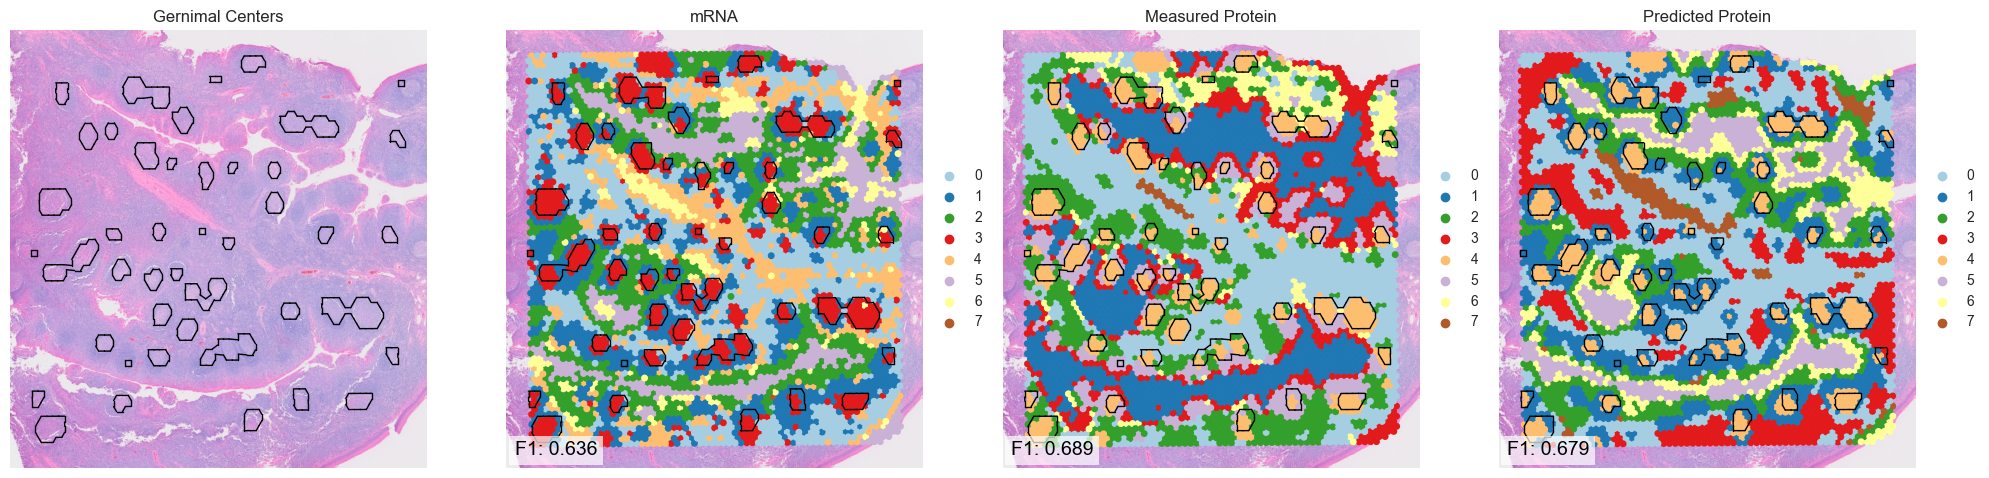

In [9]:
leiden_plot_eva(adata_Tonsil2,pdata_Tonsil2,predata_Tonsil2,resolution_list = resolution_list, n_neighbor_list=neighbor_list, points=points,edges=edges,size = 1.7, palette = 'tab20',save_fig = False, true_label_key ='pathology',plot_type='F1')

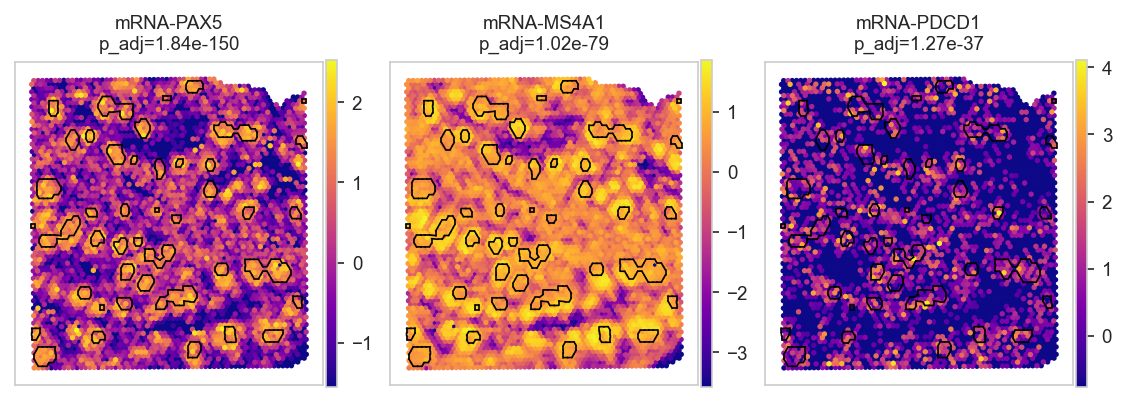

In [10]:
sc.tl.rank_genes_groups(adata_Tonsil2, groupby='pathology', method="wilcoxon",alternative='greater')
plot_spatial_expression(adata_Tonsil2, ['PAX5','MS4A1','PDCD1'], points, edges, 'mRNA')

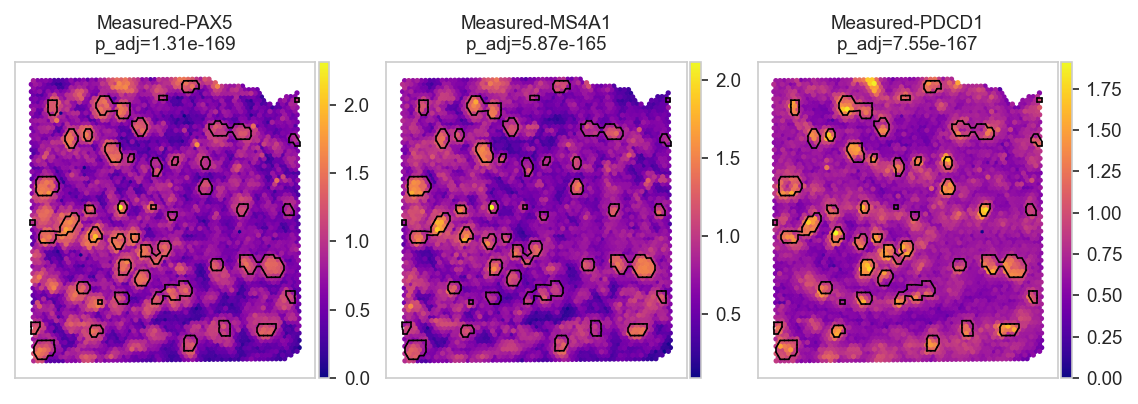

In [11]:
sc.tl.rank_genes_groups(pdata_Tonsil2, groupby='pathology', method="wilcoxon",alternative='greater')
plot_spatial_expression(pdata_Tonsil2, ['PAX5','MS4A1','PDCD1'], points, edges, 'Measured')

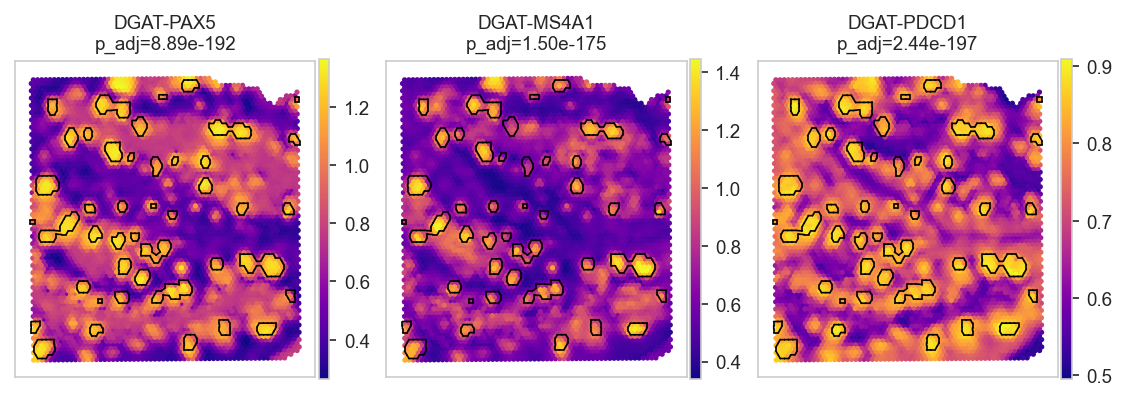

In [12]:
sc.tl.rank_genes_groups(predata_Tonsil2, groupby='pathology', method="wilcoxon",alternative='greater')
plot_spatial_expression(predata_Tonsil2, ['PAX5','MS4A1','PDCD1'], points, edges, 'DGAT')

## Prediction on ST data

Lymph Node

In [13]:
import tarfile
if not hasattr(tarfile, 'data_filter'):
    tarfile.data_filter = None 

import scanpy as sc
adata_LN = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_LN.var_names_make_unique()
celltypes = pd.read_csv("./resources/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("./resources/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)
obs_names = np.intersect1d(celltypes.index, adata_LN.obs_names)
adata_LN = adata_LN[obs_names]
celltypes = celltypes.loc[obs_names]
gc_annotation = gc_annotation.loc[obs_names]

adata_LN.obsm['celltype'] = celltypes
adata_LN.obsm['celltype'].columns = [x.replace('mean_spot_factors','') for x in adata_LN.obsm['celltype'].columns]
adata_LN.obsm['celltype_raw'] = adata_LN.obsm['celltype'].copy()
adata_LN.obsm['celltype'] = adata_LN.obsm['celltype'].divide(adata_LN.obsm['celltype'].sum(axis=1), axis=0)
adata_LN.obs['germinal_center'] = gc_annotation
adata_LN.obs['germinal_center'] = adata_LN.obs['germinal_center'].map({0: "Other", 1: "GC"})
df_celltype = merge_celltypes(adata_LN)
adata_LN.obsm['celltype_major'] = df_celltype
preprocess_ST(adata_LN)
adata_LN = fill_genes(adata_LN, common_gene)


Sample lost 0 genes, 17434 in total


In [14]:
points, edges = find_edges(adata_LN)
pdata_LN = protein_predict(adata_LN,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'V1_Human_Lymph_Node' from './pyg_data/V1_Human_Lymph_Node_17434_spatial=6_testing.pth'
Dataset ready


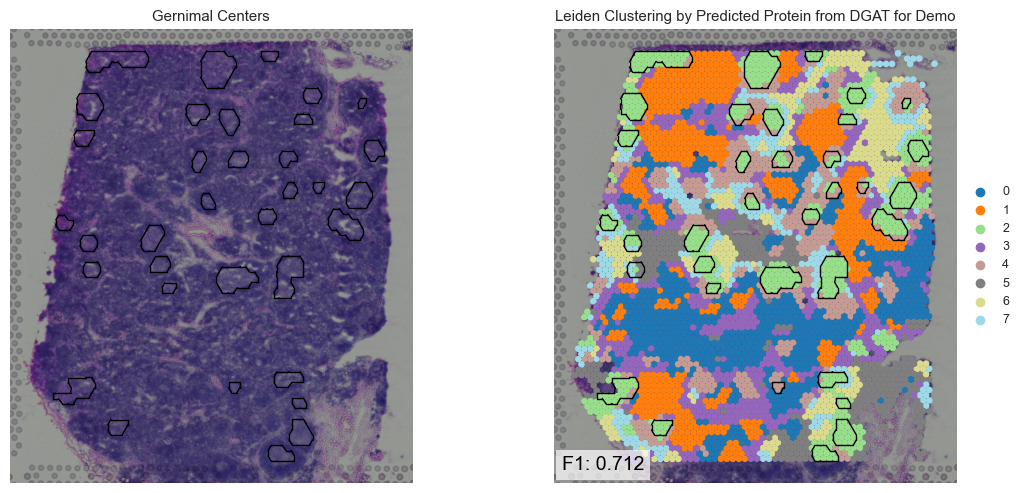

In [15]:
pdata_LN = leiden_plot(pdata_LN,n_neighbors = 10, points = points, edges = edges, plot_type = 'F1', resolution = 0.25,size = 1.7,title=f'Leiden Clustering by Predicted Protein from DGAT for Demo', palette = 'tab20',save_fig = False)


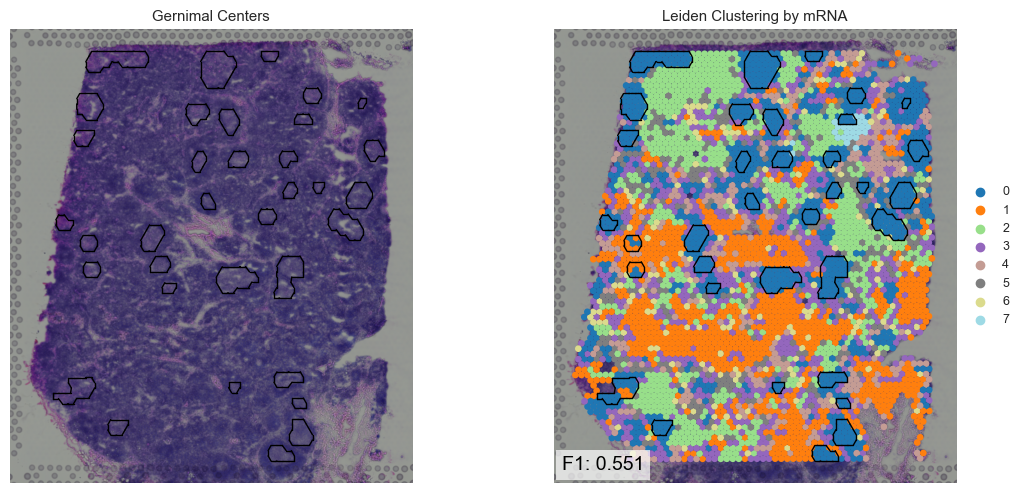

In [16]:
adata_LN = leiden_plot(adata_LN,n_neighbors = 10, points = points, edges = edges, plot_type = 'F1', resolution = 1.3,size = 1.7,title=f'Leiden Clustering by mRNA', palette = 'tab20',save_fig = False)


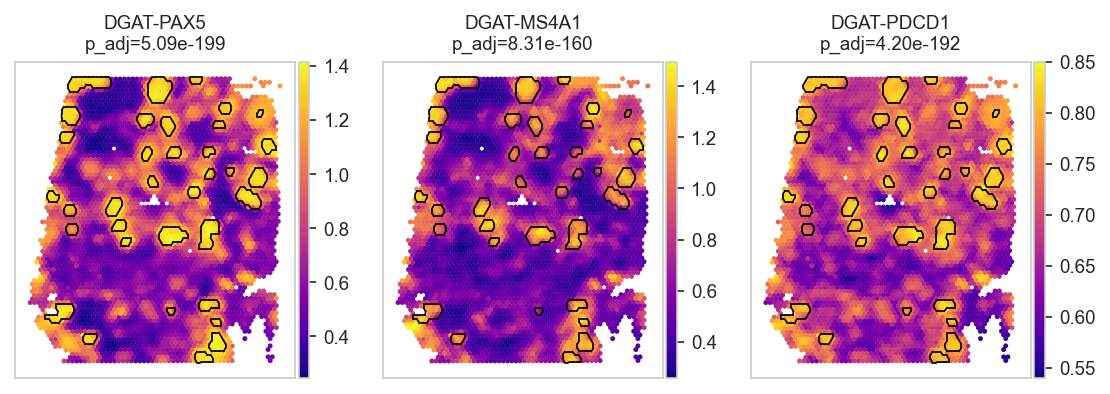

In [17]:
sc.tl.rank_genes_groups(pdata_LN, groupby='germinal_center', method="wilcoxon",alternative='greater')
plot_spatial_expression(pdata_LN, ['PAX5','MS4A1','PDCD1'], points, edges, 'DGAT')

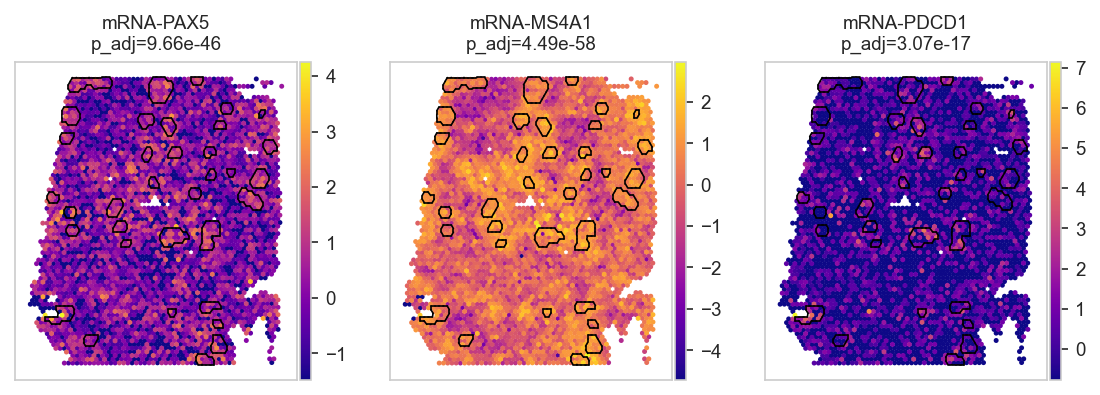

In [18]:
sc.tl.rank_genes_groups(adata_LN, groupby='germinal_center', method="wilcoxon",alternative='greater')
plot_spatial_expression(adata_LN, ['PAX5','MS4A1','PDCD1'], points, edges, 'mRNA')

In [19]:
df_ct_exp = infer_celltype_activity(pdata_LN)
df_filtered = df_ct_exp.query("neg_log_p_adj>5").query("coef>20")
pt_list = df_filtered['pt'].unique()
ct_list = df_filtered['ct'].unique()
print(pt_list)
print(ct_list)

['ACTA2' 'BCL2' 'CCR7' 'CD14' 'CD163' 'CD19' 'CD27' 'CD274' 'CD3E' 'CD4'
 'CD40' 'CD68' 'CD8A' 'CEACAM8' 'CR2' 'CXCR5' 'EPCAM' 'FCGR3A' 'HLA_DRA'
 'ITGAM' 'ITGAX' 'KRT5' 'MS4A1' 'PAX5' 'PCNA' 'PDCD1' 'PECAM1' 'PTPRC_1'
 'PTPRC_2' 'SDC1' 'VIM']
['B_plasma' 'Endo' 'Macrophages' 'Monocytes' 'NKT' 'T_CD8+' 'VSMC'
 'T_CD4+' 'T_Treg' 'T_TfR' 'DC' 'B_activated' 'B_Cycling' 'B_GC' 'B_mem'
 'FDC' 'B_preGC']


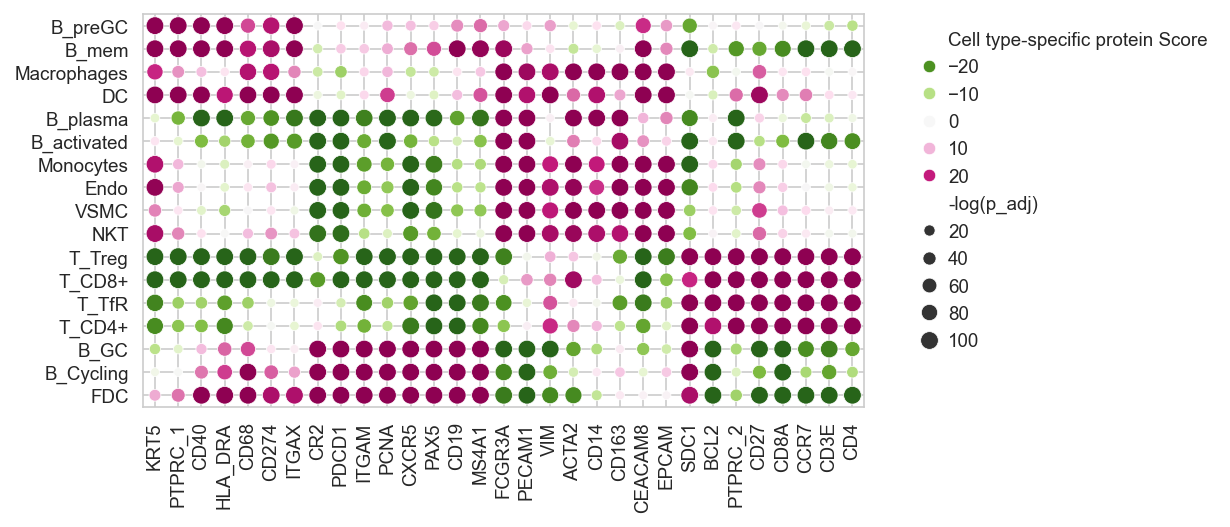

In [20]:
plot_heatmap(df_ct_exp, pt_list, ct_list, clip=25)